<a href="https://colab.research.google.com/github/gabrielpetersson/simple-variational-auto-encoder/blob/master/auto_encoder_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np


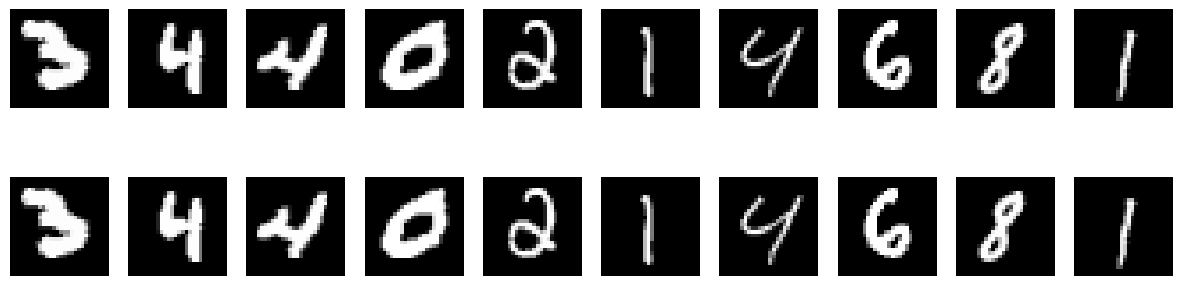

torch.Size([1, 28, 28])


In [30]:
def show_images(images, outputs, n=10):
    images = images[:n]
    outputs = outputs[:n]
    images = images.cpu().numpy()
    outputs = outputs.cpu().detach().numpy()

    # Denormalize images
    images = images * 0.5 + 0.5
    outputs = outputs * 0.5 + 0.5

    fig, axes = plt.subplots(nrows=2, ncols=n, sharex=True, sharey=True, figsize=(15,4))

    for images_row, row in zip([images, outputs], axes):
        for img, ax in zip(images_row, row):
            img = np.squeeze(img)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
    plt.show()


transform = transforms.Compose([
    transforms.RandomCrop(28, padding=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

for images, labels in train_loader:
  show_images(images, images)
  print(images[0].shape)
  break

In [36]:
import torch
import torch.nn as nn

bottleneck = 16
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # [B, 32, 14, 14]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [B, 64, 7, 7]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # [B, 128, 4, 4]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Linear(128 * 4 * 4, bottleneck),  # Bottleneck
            nn.BatchNorm1d(bottleneck),
            nn.LeakyReLU(0.2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck, 128 * 4 * 4),
            nn.BatchNorm1d(128 * 4 * 4),
            nn.LeakyReLU(0.2),

            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # [B, 64, 7, 7]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [B, 32, 14, 14]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            # Adjust final layer for exact 28x28 output
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # [B, 1, 28, 28]
            nn.Tanh()  # Output layer
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded


Initial loss 1.100057409477234


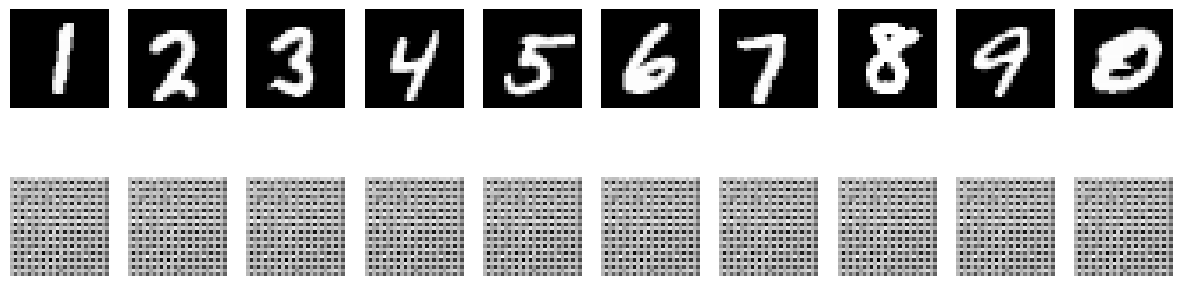

tensor([ 7,  5, 14,  8,  9,  6,  7, 15,  8,  6], device='cuda:0')


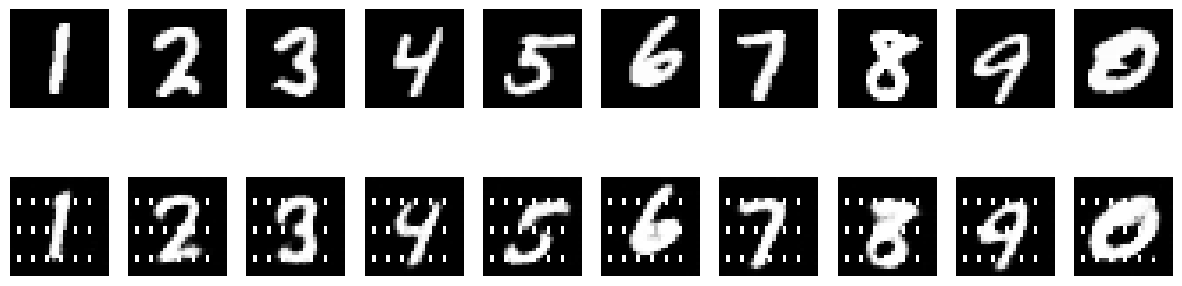

Epoch [1/10], Training Loss: 0.2915, Validation Loss: 0.1636
tensor([ 7, 10,  5, 10, 14,  2, 10, 12,  8,  6], device='cuda:0')


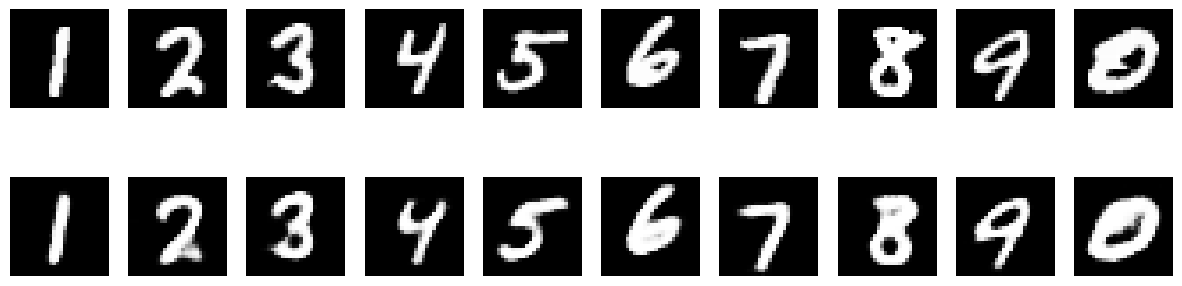

Epoch [2/10], Training Loss: 0.0996, Validation Loss: 0.0813
tensor([ 7, 10,  5,  6,  9,  2,  8, 15,  8,  6], device='cuda:0')


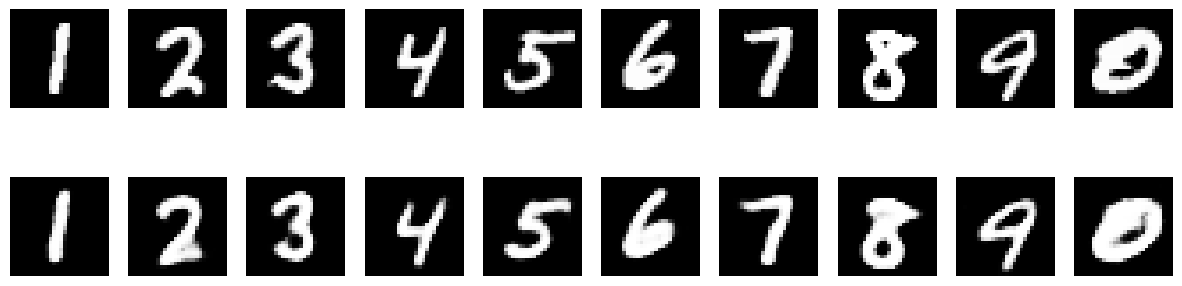

Epoch [3/10], Training Loss: 0.0818, Validation Loss: 0.0741
tensor([ 1, 10,  5,  6, 14,  2,  7,  9, 15,  2], device='cuda:0')


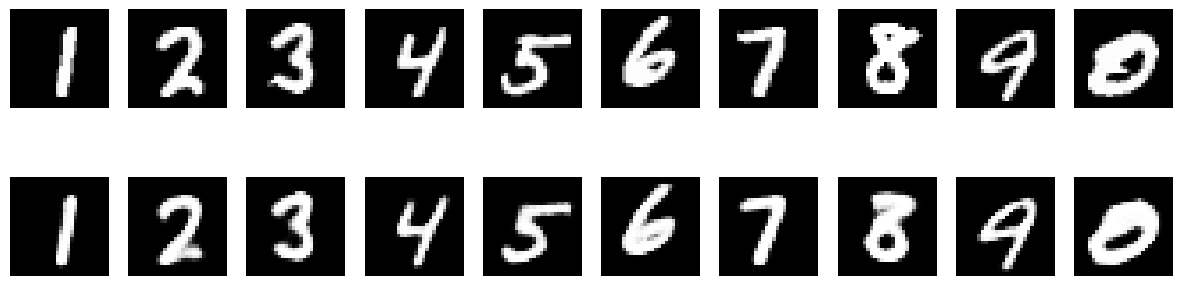

Epoch [4/10], Training Loss: 0.0764, Validation Loss: 0.0688
tensor([ 1, 10, 15,  8,  4,  2,  7,  9, 15,  6], device='cuda:0')


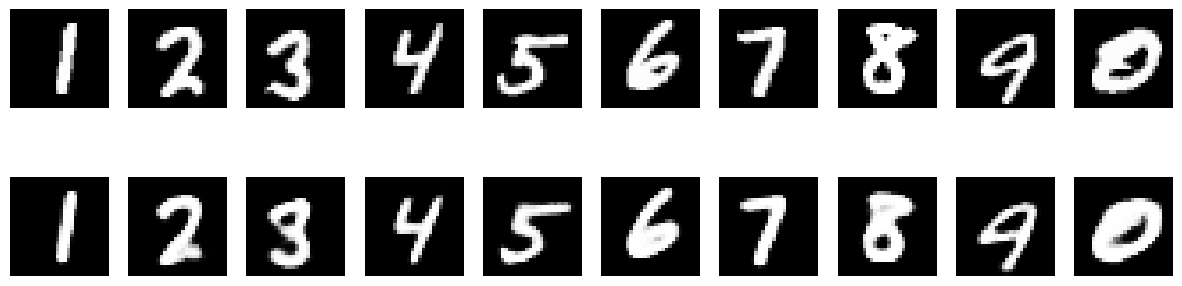

Epoch [5/10], Training Loss: 0.0732, Validation Loss: 0.0659
tensor([1, 5, 1, 8, 4, 7, 8, 9, 8, 6], device='cuda:0')


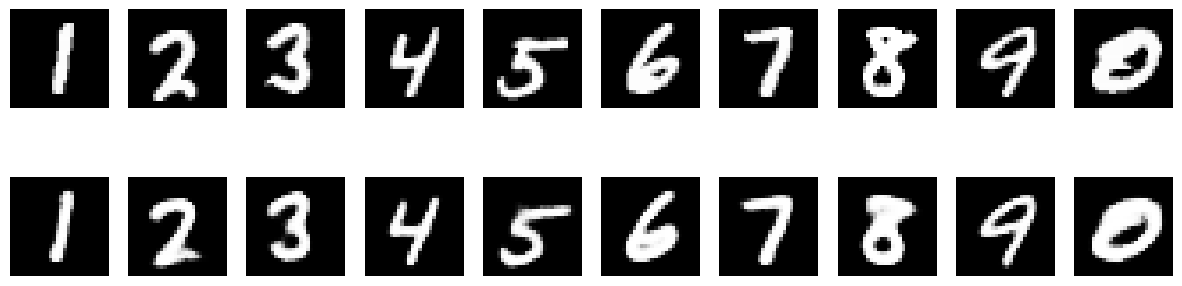

Epoch [6/10], Training Loss: 0.0709, Validation Loss: 0.0636
tensor([ 1,  5,  1,  8,  4,  7, 15,  9,  8,  6], device='cuda:0')


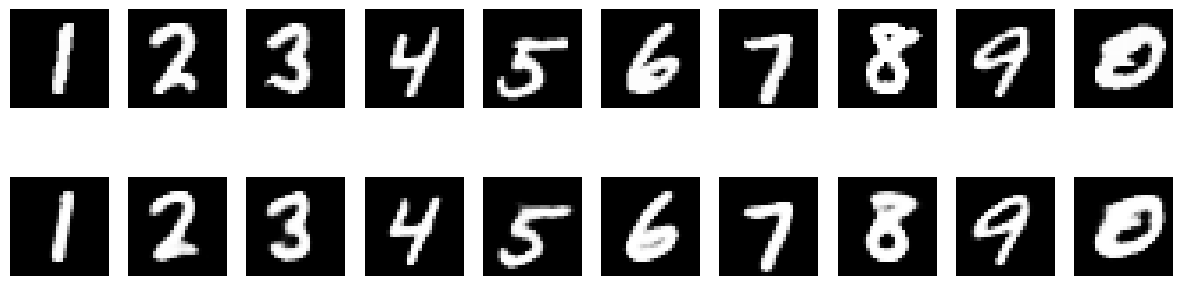

Epoch [7/10], Training Loss: 0.0690, Validation Loss: 0.0620
tensor([ 1,  5,  1,  6, 14,  7,  5,  9,  8,  6], device='cuda:0')


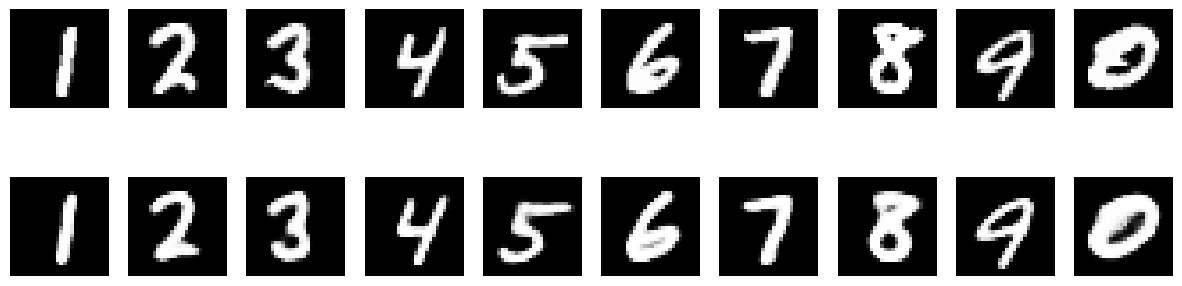

Epoch [8/10], Training Loss: 0.0675, Validation Loss: 0.0605
tensor([ 1, 10, 15,  8, 14, 12,  8,  9,  8,  6], device='cuda:0')


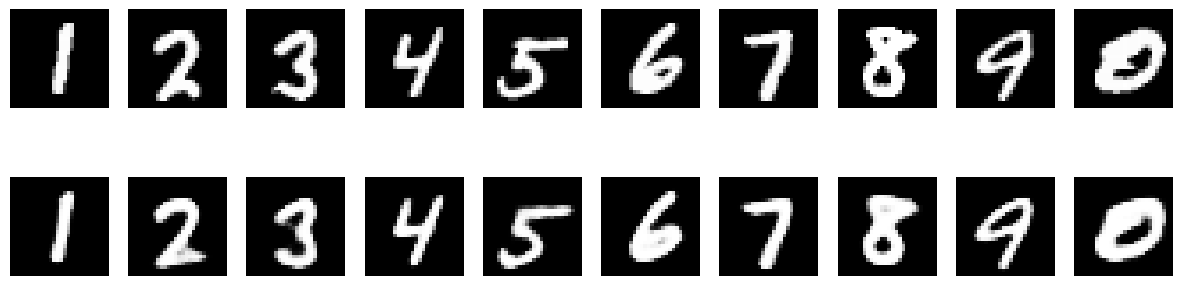

Epoch [9/10], Training Loss: 0.0665, Validation Loss: 0.0594
tensor([ 1,  5,  5,  8, 14,  2,  8,  9, 15,  6], device='cuda:0')


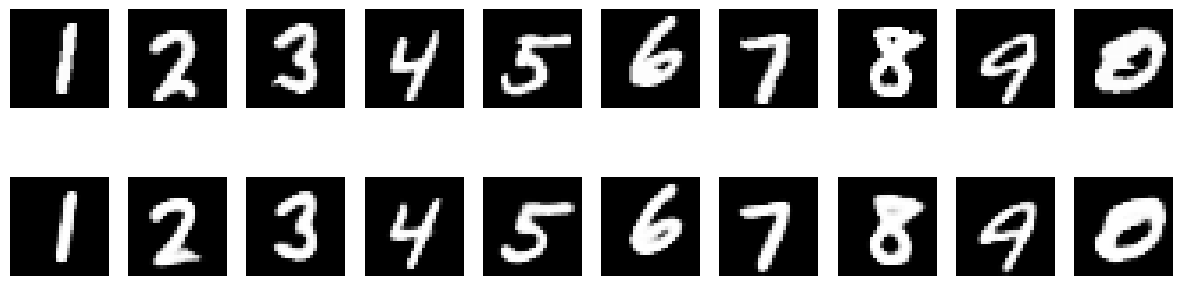

Epoch [10/10], Training Loss: 0.0655, Validation Loss: 0.0590


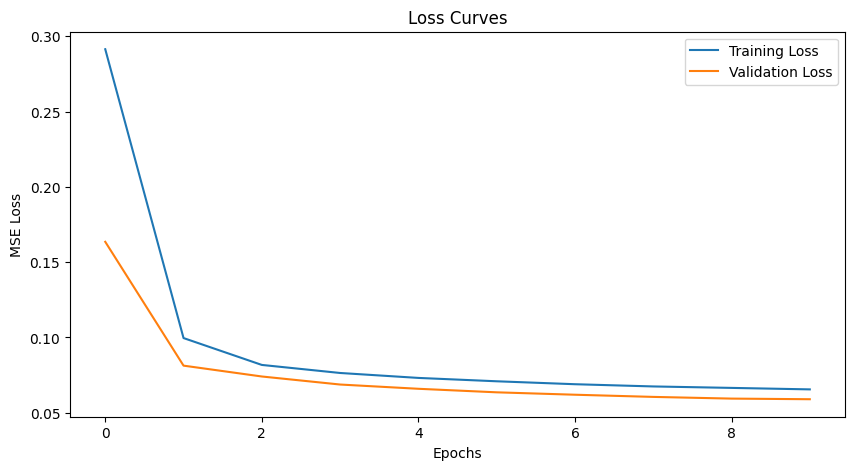

In [37]:
# Hyperparameters
num_epochs = 10
learning_rate = 1e-3

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store losses
train_losses = []
val_losses = []


model.eval()
val_loss = 0
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs, _ = model(images)
        loss = criterion(outputs, images)
        val_loss += loss.item() * images.size(0)
    val_loss /= len(test_loader.dataset)
    print("Initial loss", val_loss)
    show_images(images, outputs)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)

        # Forward pass
        outputs, _ = model(images)
        loss = criterion(outputs, images)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    # Average training loss
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs, decoded = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item() * images.size(0)

        # Average validation loss
        val_loss /= len(test_loader.dataset)
        val_losses.append(val_loss)

        print(torch.argmax(decoded[:10], dim=1))
        # Save reconstructed images
        show_images(images[:10], outputs[:10])

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

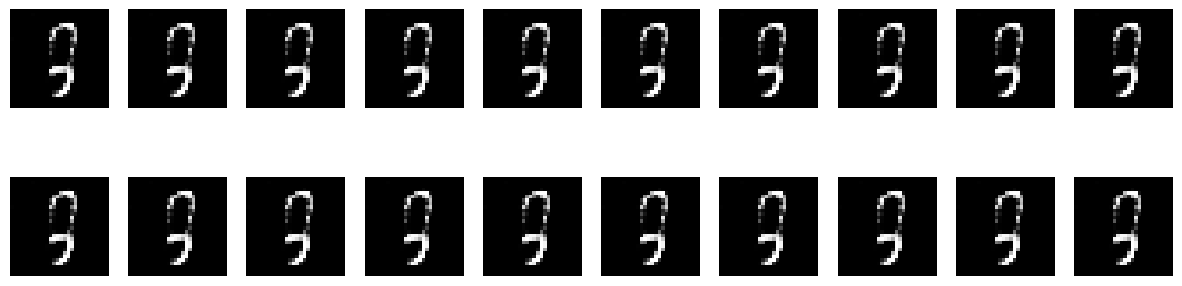

In [55]:
model.eval()
with torch.no_grad():
    random_inputs = torch.zeros(10, bottleneck).to("cuda")
    outputs = model.decoder(random_inputs)
    show_images(outputs[:10], outputs[:10])